In [1]:
import scanpy as sc
import squidpy as sq
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
import copy

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
from algorithms import *
from data_gen import *
from spectrum_gen import *
from visualizations import *
from analysis import *
import os
from ipylab import JupyterFrontEnd
from algorithms_torch import *
from data_gen import *
from datasets import *
import time
import torch
torch.cuda.get_device_name()

'NVIDIA GeForce GTX TITAN Black'

In [2]:
adata_all = sc.read('pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')
adata_all

/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


AnnData object with n_obs × n_vars = 14693 × 2448
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [3]:
adata_all.shape

(14693, 2448)

In [4]:
counts = adata_all.obs.celltype.value_counts()
counts

alpha                     4214
beta                      3354
ductal                    1804
acinar                    1368
not applicable            1154
delta                      917
gamma                      571
endothelial                289
activated_stellate         284
dropped                    178
quiescent_stellate         173
mesenchymal                 80
macrophage                  55
PSC                         54
unclassified endocrine      41
co-expression               39
mast                        32
epsilon                     28
mesenchyme                  27
schwann                     13
t_cell                       7
MHC class II                 5
unclear                      4
unclassified                 2
Name: celltype, dtype: int64

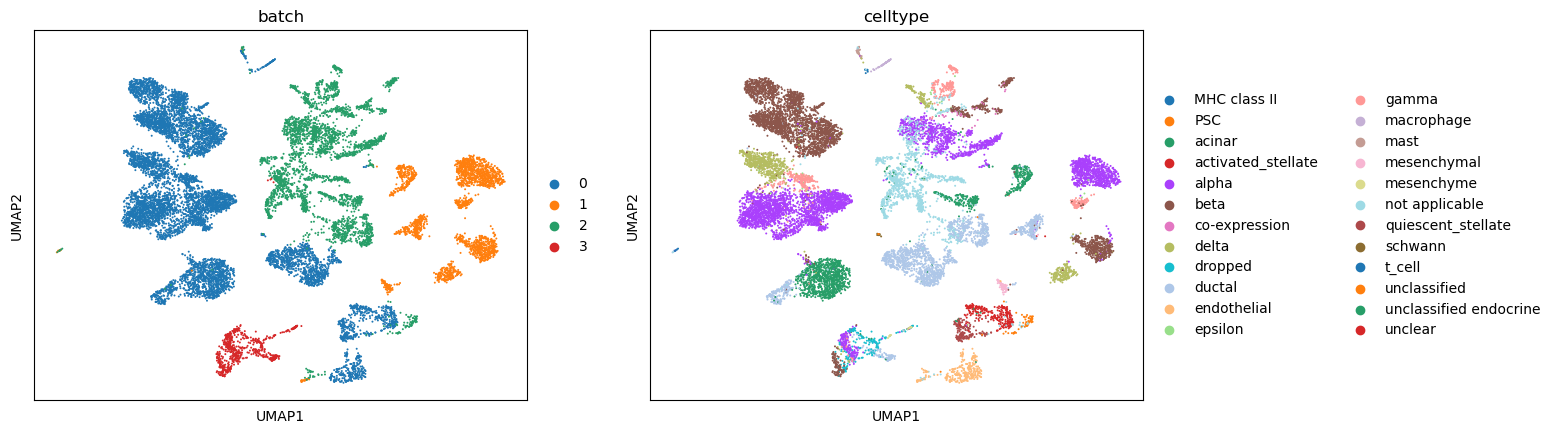

In [5]:
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)
sc.pl.umap(adata_all, color=['batch', 'celltype'], palette=sc.pl.palettes.vega_20_scanpy)

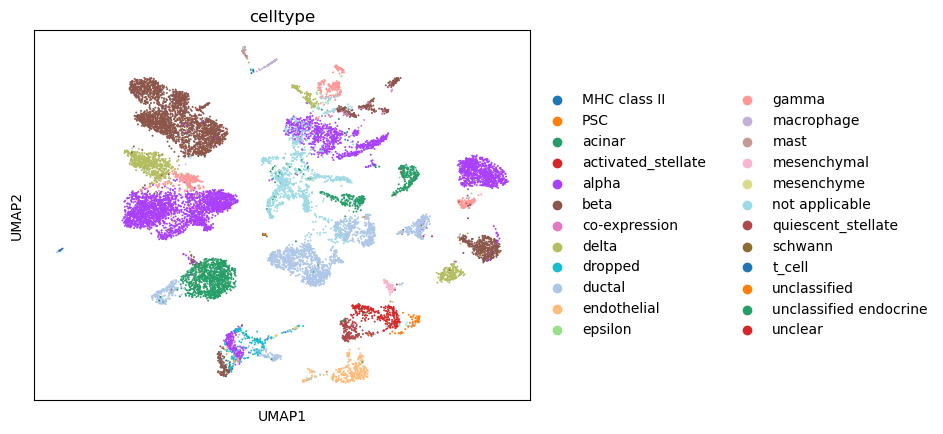

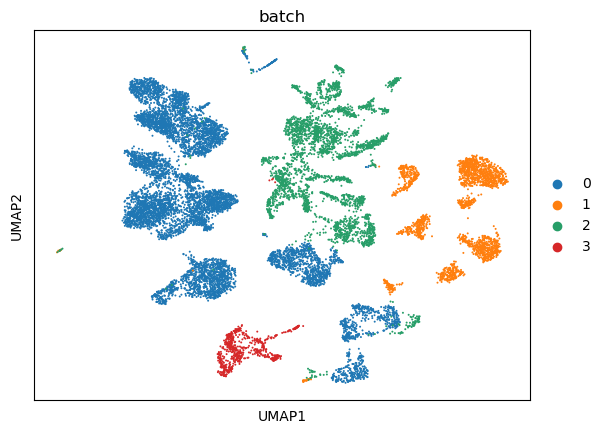

In [6]:
sc.pl.umap(adata_all, color= 'celltype', palette=sc.pl.palettes.vega_20_scanpy)
sc.pl.umap(adata_all, color= 'batch', palette=sc.pl.palettes.vega_20_scanpy)

In [7]:
adata = sort_data_crit(adata=adata_all.copy(),crit='batch',crit_list=['0', '1', '2', '3'] ) #sort the tree
adata.obs['batch']

index
human2_lib2.final_cell_0186-0    0
human3_lib2.final_cell_0245-0    0
human2_lib1.final_cell_0045-0    0
human3_lib4.final_cell_0884-0    0
human2_lib3.final_cell_0441-0    0
                                ..
reads.16175-3                    3
reads.29364-3                    3
reads.26087-3                    3
reads.25943-3                    3
reads.26123-3                    3
Name: batch, Length: 14693, dtype: category
Categories (4, object): ['0', '1', '2', '3']

In [8]:
batches_array = np.array(adata.obs['batch']).astype('float64')

In [9]:
unique, counts = np.unique(batches_array, return_counts=True)
counts

array([8569, 2126, 3363,  635])

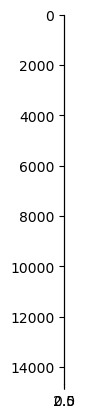

In [10]:
VT = np.zeros((len(batches_array),4))
VT[:8569,0]=1
VT[8569:8569+2126,1]=1
VT[8569+2126:8569+2126+3363,2]=1
VT[8569+2126+3363:8569+2126+3363+635,3]=1
plt.imshow(VT)

In [11]:
F1 =filter_general_topology_torch(np.array(adata.X).astype('float64'), VT, regu=0,iterNum=500)


0
cuda
starting filtering
Iteration number: 1
Iteration number: 101
Iteration number: 201
Iteration number: 301
Iteration number: 401
torch.cuda.memory_allocated: 2.548100GB


In [13]:
adata_filtered = adata.copy()
adata_filtered.X = adata_filtered.X *F1.cpu().numpy()

In [14]:
sc.pp.pca(adata_filtered)
sc.pp.neighbors(adata_filtered)
sc.tl.umap(adata_filtered)

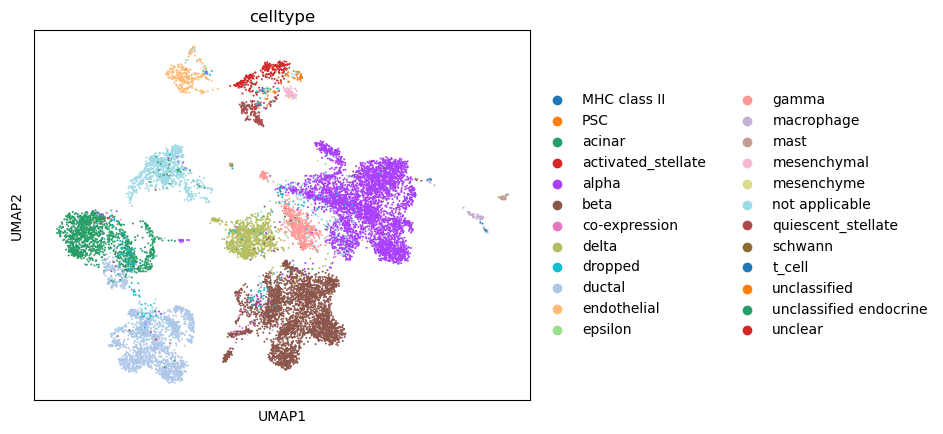

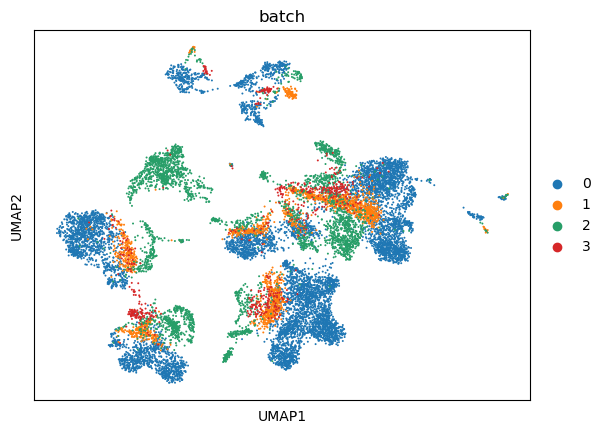

In [15]:
sc.pl.umap(adata_filtered, color= 'celltype', palette=sc.pl.palettes.vega_20_scanpy)
sc.pl.umap(adata_filtered, color= 'batch', palette=sc.pl.palettes.vega_20_scanpy)

In [16]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

In [17]:
calinski_harabasz_score(adata_filtered.X, adata_filtered.obs['celltype'])

107.48550979732764

In [18]:
calinski_harabasz_score(adata.X, adata.obs['celltype'])

90.96603503687568

In [19]:
calinski_harabasz_score(adata_filtered.X, adata_filtered.obs['batch'])

3.7982565220502833

In [20]:
calinski_harabasz_score(adata.X, adata.obs['batch'])

298.62916751562466

In [ ]:
silhouette_score(adata_filtered.X, adata_filtered.obs['celltype'])

In [ ]:
silhouette_score(adata.X, adata.obs['celltype'])

In [ ]:
silhouette_score(adata_filtered.X, adata_filtered.obs['batch'])

In [ ]:
silhouette_score(adata.X, adata.obs['batch'])

In [21]:
del F1


In [22]:
torch.cuda.empty_cache()